In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
import random
import matplotlib as mpl

In [2]:
# Generates rewards matrix of size (2, ktrials, Nflies, precision, precision)
# rb is 0 and ry is a list of 0 and 1 with a variable proprtion

def create_rewards(ktrials,Nflies,precision):
    ry=np.empty((ktrials,Nflies,precision,precision))
    for i in range (ktrials):
        ry[i]=bernoulli.rvs(p,size=((Nflies,precision,precision)))

    rb=np.zeros(precision)
    
    rewards=np.asarray(np.empty((2,ktrials,Nflies,precision,precision)))
    rewards[0]=rb
    rewards[1]=ry
    return (rewards)

In [3]:
# Generates choice array  of size (2,Nflies,precision,precision)

def choice (mb,my):
    Py = np.exp(beta * my) / (np.exp(beta * my) + np.exp(beta * mb))
        
    cy = bernoulli.rvs(Py)
    cb = - cy +1
    return [cb,cy]

In [4]:
# Returns the estimated and effective rewards, and the energy spent.
# Respectively 2 arrays of size (Nflies,precision,precision), an array of size (ktrials,Nflies,precision,precision) and an array of size (Nflies,precision,precision) 

def r_E_calcul(cb,cy,r_E_variables,rewards,i):
    r_E_variables["expected_rb"] = (1 - lambda_r * cb) * r_E_variables["expected_rb"] + lambda_r*rewards[0][i] * cb
    r_E_variables["expected_ry"] = (1 - lambda_r * cy) * r_E_variables["expected_ry"] + lambda_r*rewards[1][i] * cy
    
    r_E_variables["E"] = r_E_variables["E"] + (abs(r_E_variables["dmb"]) + abs(r_E_variables["dmy"]))*energy_factor
    
    r_E_variables["reward_received"][i] = rewards[0][i]*cb+rewards[1][i]*cy
      
    return[r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]

In [5]:
# Generates an array of the mean reward received and energy spent, of size (2,precision, precision)

def reward_energy(rewards, beta, lambda_r, lambda_ARM):
    m_max=1
    x=1
    
    eps = np.linspace(np.zeros(precision),np.ones(precision)*1,precision)
    
    mb = np.zeros((Nflies,precision,precision))
    my = np.zeros((Nflies,precision,precision))
    
    r_E_variables = { "expected_rb" : np.zeros((Nflies,precision,precision)),
                    "expected_ry" : np.zeros((Nflies,precision,precision)),
                    "reward_received" : np.empty((ktrials,Nflies,precision,precision)),
                    "E" : np.zeros((Nflies,precision,precision))}
    
    reward_E = np.empty((2,precision, precision))
    
    for i in range (ktrials) :
        
        [cb,cy]=choice(mb,my)
        
        mb -= mb * lambda_ARM
        r_E_variables["dmb"] = cb * eps * (rewards[0][i] - r_E_variables["expected_rb"]) * (x - mb/m_max)
        
        b_positive_correction=np.where(mb + r_E_variables["dmb"] < 0)
        r_E_variables["dmb"][b_positive_correction]= 0 - mb[b_positive_correction]
        
        b_max_correction=np.where(mb + r_E_variables["dmb"] > m_max)
        r_E_variables["dmb"][b_max_correction]= m_max - mb[b_max_correction]
        
        mb += r_E_variables["dmb"]
        
        my -= my * lambda_ARM
        r_E_variables["dmy"] = cy * eps * (rewards[1][i] - r_E_variables["expected_ry"]) * (x - my/m_max)
        
        y_positive_correction=np.where(my + r_E_variables["dmy"] < 0)
        r_E_variables["dmy"][y_positive_correction]= 0 - my[y_positive_correction]
        
        y_max_correction=np.where(my + r_E_variables["dmy"] > m_max)
        r_E_variables["dmy"][y_max_correction]= m_max - my[y_max_correction]
        
        my += r_E_variables["dmy"]
    
        
        [r_E_variables["expected_rb"],r_E_variables["expected_ry"],r_E_variables["reward_received"], r_E_variables["E"]]=r_E_calcul(cb,cy,r_E_variables,rewards,i)
    reward_E[0] = sum(sum(r_E_variables["reward_received"]))/Nflies
    reward_E[1] = sum(r_E_variables["E"])/Nflies
    return reward_E

In [6]:
# Parameters setting
Nflies = 100
ktrials = 200
precision = 101
lambda_r=0.1
beta=7
energy_factor = 30
p=np.linspace(0,1,precision)

In [7]:
# Generates an array of the mean reward received and energy spent, using LTM or ARM only, of size (2,2,precision, precision)
# Note : all_reward_E[1,1], which should correspond to the energy spent using ARM isn't accurate, ase the ARM do not consume energy.
all_reward_E = np.empty((2,2,precision,precision))
all_reward_E[0] = reward_energy(create_rewards(ktrials,Nflies,precision), beta, lambda_r, 0)
all_reward_E[1] = reward_energy(create_rewards(ktrials,Nflies,precision), beta, lambda_r,1/2.5)

In [8]:
# Generates an array of the the mean performance
# Size (2,precision, precision)
mean_random_r=100*p
max_r=200*p
perf = np.empty((2,precision,precision))
perf[0] = (all_reward_E[0,0] - mean_random_r) / (max_r - mean_random_r)
perf[1] = (all_reward_E[1,0] - mean_random_r) / (max_r - mean_random_r)

/var/folders/zf/tw6675q13m14kfmvcjj4h4s40000gn/T/ipykernel_3997/2744627840.py:6: RuntimeWarning: invalid value encountered in true_divide
  perf[0] = (all_reward_E[0,0] - mean_random_r) / (max_r - mean_random_r)
/var/folders/zf/tw6675q13m14kfmvcjj4h4s40000gn/T/ipykernel_3997/2744627840.py:7: RuntimeWarning: invalid value encountered in true_divide
  perf[1] = (all_reward_E[1,0] - mean_random_r) / (max_r - mean_random_r)


In [9]:
# Generates an array of the difference between the reward received using LTM and using ARM
#Size (precision, precision)
LTM_less_ARM = perf[0] - perf[1]

# Generates an array of the energy gain of the LTM model
# Size (precision, precision)
LTM_E_gain = all_reward_E[0,0] - all_reward_E[0,1]- all_reward_E[1,0]

In [10]:
# Plots the chosen parameter as a fonction of beta and the mean reward which would be received without learning

def Plot(P,Title,norm):
    plt.colorbar(plt.imshow(P, origin="lower",cmap="jet",norm=norm))
    plt.xlabel('Reward probability on the yellow flower (%)')
    plt.ylabel('Epsilon')
    ticks=[0,20,40,60,80,100]
    r_label=["0", "20", "40", "60", "80", "100"]
    plt.xticks(ticks, r_label)
    eps_label=["0", "0.2", "0.4", "0.6", "0.8", "1"]
    plt.yticks(ticks, eps_label)
    plt.title(Title)

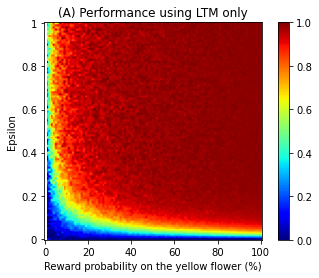

In [11]:
#Plot of the performance using LTM only 
Plot(perf[0],"(A) Performance using LTM only",mpl.colors.Normalize(vmin=0, vmax=1))

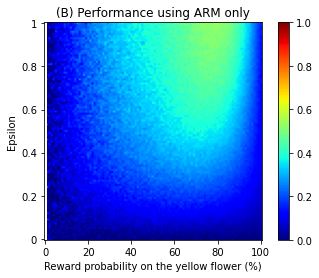

In [12]:
#Plot of the performane using ARM only 
Plot(perf[1],"(B) Performance using ARM only",mpl.colors.Normalize(vmin=0, vmax=1))

/var/folders/zf/tw6675q13m14kfmvcjj4h4s40000gn/T/ipykernel_3997/1716464747.py:2: RuntimeWarning: invalid value encountered in true_divide
  ARM_50_perf=(reward_energy(create_rewards(ktrials,Nflies,precision), beta, lambda_r,0.5)[0]- mean_random_r) / (max_r - mean_random_r)


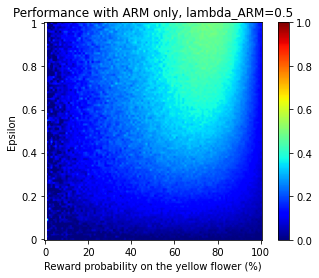

In [13]:
# Plot of the supplementary rewards obtained thanks to learning with ARM only for a decay rate of 0.5
ARM_50_perf=(reward_energy(create_rewards(ktrials,Nflies,precision), beta, lambda_r,0.5)[0]- mean_random_r) / (max_r - mean_random_r)
Plot(ARM_50_perf,"Performance with ARM only, lambda_ARM=0.5",mpl.colors.Normalize(vmin=0, vmax=1))

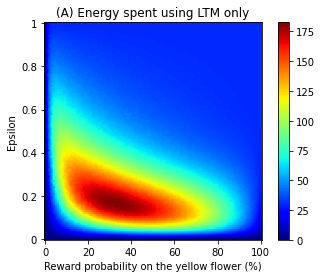

In [14]:
# Plot of the energy spent using LTM only 
Plot(all_reward_E[0,1],"(A) Energy spent using LTM only",None)

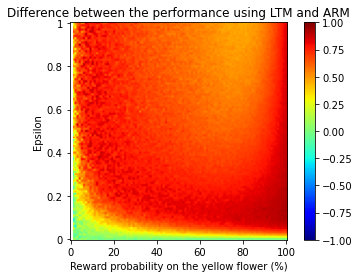

In [15]:
#Plot of the difference between the performance of the model using LTM and the model using ARM
Plot(LTM_less_ARM,"Difference between the performance using LTM and ARM",mpl.colors.Normalize(vmin=-1, vmax=1))

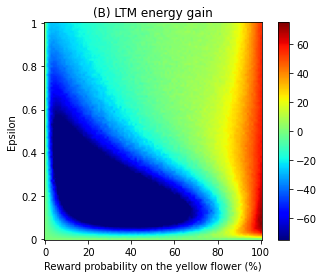

In [16]:
#Plot of the energy gain of the LTM model
Plot(LTM_E_gain,"(B) LTM energy gain",mpl.colors.Normalize(vmin=-75, vmax=75))